# ML &mdash; HW №1
# А.&#8201;Д. Егоров



In [1]:
import numpy as np 
import pandas as pd

import re

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import seaborn as sns

# USE THIS STYLE
# plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
# 
# OR THIS STYLE
import aquarel

theme = aquarel.load_theme("arctic_light")
theme.set_font(family="serif")
theme.apply()

## Импортируем данные

In [2]:
df_train = pd.read_csv("./data/train.csv")
df_submit = pd.read_csv("./data/test.csv")

In [3]:
df_train.head(5)

,client_id,регион,использование,сумма,частота_пополнения,доход,сегмент_arpu,частота,объем_данных,on_net,продукт_1,продукт_2,зона_1,зона_2,mrg_,секретный_скор,pack,pack_freq,binary_target
0,0,Уран,>24LY,14.617797,1.0,27034.974914,71.37,1.000000,NaN,26.0,10.0,NaN,NaN,NaN,False,0.540984,_output-_сеть 500 (условие) 2000f;5d,1.000000,0
1,1,Марс,>24LY,32.686083,3.0,40373.828300,354.27,2.000000,35.679126,45.0,8.0,NaN,NaN,NaN,False,0.573770,тариф_a 250 (условие) _безлим_c_output_сутки,1.414214,0
2,2,Церера,>24LY,25.318570,3.0,32004.378374,139.74,1.414214,NaN,NaN,13.0,NaN,NaN,NaN,False,0.131148,NaN,NaN,0
3,3,Марс,>24LY,70.710678,38.0,59953.505011,1722.65,6.403124,163.309522,203.0,274.0,NaN,NaN,0.031817,False,0.885246,"трафик: 100 (условие) 40mb,_сутки",4.000000,0
4,4,Меркурий,>24LY,9.244999,2.0,21499.998428,28.63,1.414214,5.000000,NaN,NaN,NaN,NaN,NaN,False,0.344262,"трафик: 100 (условие) 40mb,_сутки",1.000000,0


In [5]:
df_train.shape, df_submit.shape

((1010248, 19), (497586, 18))

## Предобработка данных

### Переименуем колонки

In [3]:
new_names = {
    "client_id" : "client_id" ,
    "регион": "region",
    "использование": "usage",
    "сумма": "sum",
    "доход": "income",
    "частота_пополнения": "repl_freq",
    "сегмент_arpu": "segment_arpu",
    "частота": "freq",
    "объем_данных": "data_volume",
    "on_net": "on_net",
    "продукт_1": "product_1",
    "продукт_2": "product_2",
    "зона_1": "zone_1",
    "зона_2": "zone_2",
    "mrg_": "mrg",
    "секретный_скор": "secret_score",
    "pack": "pack",
    "pack_freq": "pack_freq",
    "binary_target": "binary_target",
}

df_train = df_train.rename(columns=new_names).drop(columns=["client_id"])
# таблица для submission
submission = df_submit["client_id"].to_frame()
df_submit = df_submit.rename(columns=new_names).drop(columns=["client_id"])

df_train.head(5)

,region,usage,sum,repl_freq,income,segment_arpu,freq,data_volume,on_net,product_1,product_2,zone_1,zone_2,mrg,secret_score,pack,pack_freq,binary_target
0,Уран,>24LY,14.617797,1.0,27034.974914,71.37,1.000000,NaN,26.0,10.0,NaN,NaN,NaN,False,0.540984,_output-_сеть 500 (условие) 2000f;5d,1.000000,0
1,Марс,>24LY,32.686083,3.0,40373.828300,354.27,2.000000,35.679126,45.0,8.0,NaN,NaN,NaN,False,0.573770,тариф_a 250 (условие) _безлим_c_output_сутки,1.414214,0
2,Церера,>24LY,25.318570,3.0,32004.378374,139.74,1.414214,NaN,NaN,13.0,NaN,NaN,NaN,False,0.131148,NaN,NaN,0
3,Марс,>24LY,70.710678,38.0,59953.505011,1722.65,6.403124,163.309522,203.0,274.0,NaN,NaN,0.031817,False,0.885246,"трафик: 100 (условие) 40mb,_сутки",4.000000,0
4,Меркурий,>24LY,9.244999,2.0,21499.998428,28.63,1.414214,5.000000,NaN,NaN,NaN,NaN,NaN,False,0.344262,"трафик: 100 (условие) 40mb,_сутки",1.000000,0


In [4]:
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
)

# Импорт методов автоматической обработки данных
from sklearn.model_selection import (
    train_test_split,
)

# Импорт метрик качества классификации
from sklearn.metrics import (
    f1_score,
)


### Добавим дополнительные фитчи

In [5]:
df_train["sum_income_ratio"] = df_train["sum"] / df_train["income"]
df_train["segment_arpu_income_ratio"] = df_train["segment_arpu"] / df_train["income"]

df_train["sum_repl_freq_ratio"] = df_train["sum"] / df_train["repl_freq"]
df_train["sum_repl_freq_mul"] = df_train["sum"] * df_train["repl_freq"]

df_train["income_freq_ratio"] = df_train["income"] / df_train["freq"]
df_train["income_freq_mul"] = df_train["income"] * df_train["freq"]

df_train["segment_arpu_freq_ratio"] = df_train["segment_arpu"] / df_train["freq"]
df_train["segment_arpu_freq_mul"] = df_train["segment_arpu"] * df_train["freq"]


df_submit["sum_income_ratio"] = df_submit["sum"] / df_submit["income"]
df_submit["segment_arpu_income_ratio"] = df_submit["segment_arpu"] / df_submit["income"]

df_submit["sum_repl_freq_ratio"] = df_submit["sum"] / df_submit["repl_freq"]
df_submit["sum_repl_freq_mul"] = df_submit["sum"] * df_submit["repl_freq"]

df_submit["income_freq_ratio"] = df_submit["income"] / df_submit["freq"]
df_submit["income_freq_mul"] = df_submit["income"] * df_submit["freq"]

df_submit["segment_arpu_freq_ratio"] = df_submit["segment_arpu"] / df_submit["freq"]
df_submit["segment_arpu_freq_mul"] = df_submit["segment_arpu"] * df_submit["freq"]


### Выделим численные и категориальные фитчи

In [6]:
numerical_features = [f for f in df_train.columns if df_train.dtypes[f] != "object"]
numerical_features.remove("binary_target")
print(numerical_features)

categorical_features = [f for f in df_train.columns if df_train.dtypes[f] == "object"]
print(categorical_features)

['sum', 'repl_freq', 'income', 'segment_arpu', 'freq', 'data_volume', 'on_net', 'product_1', 'product_2', 'zone_1', 'zone_2', 'mrg', 'secret_score', 'pack_freq', 'sum_income_ratio', 'segment_arpu_income_ratio', 'sum_repl_freq_ratio', 'sum_repl_freq_mul', 'income_freq_ratio', 'income_freq_mul', 'segment_arpu_freq_ratio', 'segment_arpu_freq_mul']
['region', 'usage', 'pack']


### Заполним `NaN`

`NaN` для численных фитчей  заменяем на `-1000`, для категориальных &mdash; `"NO_DATA"`

In [7]:
tmp = df_train[numerical_features].copy()
tmp.fillna(-1000, inplace=True)
df_train[numerical_features] = tmp.copy()

tmp = df_train[categorical_features].copy()
tmp.fillna("NO_DATA", inplace=True)
df_train[categorical_features] = tmp.copy()

tmp = df_submit[numerical_features].copy()
tmp.fillna(-1000, inplace=True)
df_submit[numerical_features] = tmp.copy()

tmp = df_submit[categorical_features].copy()
tmp.fillna("NO_DATA", inplace=True)
df_submit[categorical_features] = tmp.copy()

Колонка для df_submit с таргетом, для будущего скейлинга

In [8]:
df_submit["binary_target"] = 0

In [9]:
df_for_scaling = pd.concat(
    [
        df_train,
        df_submit,
    ],
    axis=0,
)

### Скейлинг численных фитч

In [10]:
scaler = StandardScaler()

scaled_features = scaler.fit_transform(
    df_for_scaling[numerical_features]
)

df_train_scaled = pd.DataFrame(scaled_features, columns=numerical_features).iloc[:df_train.shape[0]]
df_train_scaled["binary_target"] = df_for_scaling["binary_target"].iloc[:df_train.shape[0]]

df_submit_scaled = pd.DataFrame(scaled_features, columns=numerical_features).iloc[df_train.shape[0]:]
# df_submit_scaled["binary_target"] = 0

df_train_scaled.shape, df_submit_scaled.shape

((1010248, 23), (497586, 22))

In [30]:
df_train_scaled

,sum,repl_freq,income,segment_arpu,freq,data_volume,on_net,product_1,product_2,zone_1,zone_2,mrg,secret_score,pack_freq,binary_target
0,0.681131,0.713730,-0.043896,-0.094276,0.708117,-1.014099,0.230988,0.658369,-0.815740,-0.292699,-0.260043,0.0,0.267309,0.846024,0
1,0.717446,0.717871,0.515770,0.145003,0.710226,0.984679,0.251429,0.654809,-0.815740,-0.292699,-0.260043,0.0,0.357073,0.846861,0
2,0.702639,0.717871,0.164608,-0.036448,0.708991,-1.014099,-0.872804,0.663710,-0.815740,-0.292699,-0.260043,0.0,-0.854735,-1.177486,0
3,0.793871,0.790342,1.337285,1.302391,0.719511,1.230995,0.421409,1.128347,-0.815740,-0.292699,3.844672,0.0,1.209826,0.852088,0
4,0.670333,0.715801,-0.276130,-0.130426,0.708991,0.925471,-0.872804,-1.139653,-0.815740,-0.292699,-0.260043,0.0,-0.271272,0.846024,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010243,0.798649,0.751001,1.251161,1.112989,0.715672,-1.014099,0.289083,1.099864,1.176011,-0.292699,-0.260043,0.0,1.344471,0.852579,0
1010244,0.693300,0.715801,0.171396,-0.033911,0.711588,-1.014099,0.229912,0.644128,1.181975,-0.292699,-0.260043,0.0,0.267309,0.846024,0
1010245,-1.358113,-1.358925,-1.220174,-1.000450,-1.402659,-1.014099,-0.872804,-1.139653,-0.815740,-0.292699,-0.260043,0.0,-1.079143,-1.177486,1
1010246,0.786385,0.732365,1.180788,0.972382,0.714703,-1.014099,0.269718,0.695754,1.229681,-0.292699,-0.260043,0.0,1.523998,0.846024,0


### Кодирование категориальных фитч

In [11]:
encoder = OneHotEncoder(drop='first')

encoder.fit(df_for_scaling[categorical_features])
codes = encoder.transform(df_for_scaling[categorical_features]).toarray()
enc_features_names = encoder.get_feature_names_out(categorical_features)

df_train_all = pd.concat(
    [
        df_train_scaled,
        pd.DataFrame(codes, columns=enc_features_names).astype(int).iloc[:df_train.shape[0]],
    ],
    axis=1,
)

df_submit_all = pd.concat(
    [
        df_submit_scaled,
        pd.DataFrame(codes, columns=enc_features_names).astype(int).iloc[df_train.shape[0]:],
    ],
    axis=1,
)

df_train_all.shape, df_submit_all.shape


((1010248, 174), (497586, 173))

In [32]:
df_train_all

,sum,repl_freq,income,segment_arpu,freq,data_volume,on_net,product_1,product_2,zone_1,...,"pack_трафик:490 (условие) 1gb,7d",pack_трафик:50 (условие) 30mb__сутки,"pack_трафик:500 (условие) 2gb,_сутки","pack_трафик:700 (условие) 1 5gb,7d","pack_трафик:700 (условие) _пакет,7d",pack_трафик:o_сетьime_-пилот_1 5gb,pack_трафик_evc_2go_сутки,pack_трафик_mifi_10go,pack_трафик_mifi_10go_minput__ сотый,pack_трафик_mifi_20go
0,0.681131,0.713730,-0.043896,-0.094276,0.708117,-1.014099,0.230988,0.658369,-0.815740,-0.292699,...,0,0,0,0,0,0,0,0,0,0
1,0.717446,0.717871,0.515770,0.145003,0.710226,0.984679,0.251429,0.654809,-0.815740,-0.292699,...,0,0,0,0,0,0,0,0,0,0
2,0.702639,0.717871,0.164608,-0.036448,0.708991,-1.014099,-0.872804,0.663710,-0.815740,-0.292699,...,0,0,0,0,0,0,0,0,0,0
3,0.793871,0.790342,1.337285,1.302391,0.719511,1.230995,0.421409,1.128347,-0.815740,-0.292699,...,0,0,0,0,0,0,0,0,0,0
4,0.670333,0.715801,-0.276130,-0.130426,0.708991,0.925471,-0.872804,-1.139653,-0.815740,-0.292699,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010243,0.798649,0.751001,1.251161,1.112989,0.715672,-1.014099,0.289083,1.099864,1.176011,-0.292699,...,0,0,0,0,0,0,0,0,0,0
1010244,0.693300,0.715801,0.171396,-0.033911,0.711588,-1.014099,0.229912,0.644128,1.181975,-0.292699,...,0,0,0,0,0,0,0,0,0,0
1010245,-1.358113,-1.358925,-1.220174,-1.000450,-1.402659,-1.014099,-0.872804,-1.139653,-0.815740,-0.292699,...,0,0,0,0,0,0,0,0,0,0
1010246,0.786385,0.732365,1.180788,0.972382,0.714703,-1.014099,0.269718,0.695754,1.229681,-0.292699,...,0,0,0,0,0,0,0,0,0,0


Переименуем неготорые колонки (исключим не нужные символы)

In [12]:
new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in df_train_all.columns}
new_n_list = list(new_names.values())
new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
new_names

df_train_all = df_train_all.rename(columns=new_names)
df_submit_all = df_submit_all.rename(columns=new_names)

In [35]:
print(df_train_all.columns.to_list())

['sum', 'repl_freq', 'income', 'segment_arpu', 'freq', 'data_volume', 'on_net', 'product_1', 'product_2', 'zone_1', 'zone_2', 'mrg', 'secret_score', 'pack_freq', 'binary_target', 'region_', 'region__16', 'region__17', 'region__18', 'region__19', 'region__20', 'region__21', 'region__22', 'region__23', 'region__24', 'region__25', 'region__26', 'region__27', 'region__28', 'usage_15_18LY', 'usage_18_21LY', 'usage_21_24LY', 'usage_3_6LY', 'usage_6_9LY', 'usage_9_12LY', 'usage_24LY', 'pack_age3_minput__', 'pack___test4', 'pack___test6', 'pack___test7', 'pack__youth1_290', 'pack__youth4_490', 'pack__clir_permanent_liberte_mobile', 'pack___2_4__output', 'pack__', 'pack__minput__', 'pack__promo', 'pack__weekly', 'pack_1000_7', 'pack_1500_7', 'pack_150_auto', 'pack_20010mninput___valid', 'pack_200_1', 'pack_305155009', 'pack_500_3', 'pack_NO_DATA', 'pack__output_10003000finput__3000foff5d', 'pack__output_100050005d', 'pack__output_3006002d', 'pack__output_5001250f__output__1250_input___48h', 'pa

## Обучение моделей 

Разделим выборку на train и test

In [13]:
x = df_train_all.drop(columns=["binary_target"])
y = df_train_all["binary_target"]

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, stratify=y, random_state=17
)

### LightGBM

In [14]:
from lightgbm import LGBMClassifier 

#### Dummy lgb

In [41]:
clf_lgb = LGBMClassifier()

clf_lgb.fit(
    X_train,
    y_train,
)

res = clf_lgb.predict(X_test)

# Расчет f1_score
f1_score(y_test, res)

[LightGBM] [Info] Number of positive: 132499, number of negative: 574674
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2733
[LightGBM] [Info] Number of data points in the train set: 707173, number of used features: 116
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.187364 -> initscore=-1.467228
[LightGBM] [Info] Start training from score -1.467228


0.6078911827127147

### CatBoost

In [15]:
from catboost import CatBoostClassifier

#### Dummy cb

In [43]:
clf_cat = CatBoostClassifier(
    task_type="GPU",
)

clf_cat.fit(
    X_train,
    y_train,
    verbose=0,
)

# Расчет f1_score
f1_score(y_test, clf_cat.predict(X_test))

0.6069708516276281

### XGBoost

In [16]:
from xgboost import XGBClassifier

#### Dummy xgb

In [46]:
clf_xgb = XGBClassifier()

clf_xgb.fit(
    X_train,
    y_train,
    verbose=0,
)

# Расчет f1_score
f1_score(y_test, clf_xgb.predict(X_test))

0.607840680155387

## Tuning Hyperparametrs

In [ ]:
# import optuna
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import make_scorer

# kfold = KFold(n_splits=5, shuffle=False)

### Tuning Hyperparametrs LightGBM

In [78]:
# def objective(trial, data=X_train, target=y_train):

#     param = {
#         "objective": "binary",
#         "metric": "f1",
#         "n_estimators": trial.suggest_categorical("n_estimators", [583, 713, 600]),
#         "verbosity": -1,
#         "learning_rate": trial.suggest_float("learning_rate", 0.07, 0.15),
#         "reg_alpha": trial.suggest_float("reg_alpha", 7.5, 8.7),
#         "reg_lambda": trial.suggest_float("reg_lambda", 5.2, 8.7),
#         "max_depth": trial.suggest_categorical("max_depth", [5, 8, 10, 12]),
#         "num_leaves": trial.suggest_int("num_leaves", 8, 42),
#         "min_child_samples": trial.suggest_int("min_child_samples", 1, 64),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.69, 0.71),
#         "scale_pos_weight": 1.9,
#         "subsample": 0.9,
#     }
#     model = LGBMClassifier(**param)
#     scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring=make_scorer(f1_score))

#     return np.mean(scores)

In [77]:
# study_lgbm = optuna.create_study(direction = 'maximize')
# study_lgbm.optimize(objective, n_trials=50)

# best_params_cb = study_lgbm.best_params
# print("Best Hyperparameters for LightGBM:", best_params_cb)

# # Best Hyperparameters for LightGBM:
# # {
# #     "n_estimators": 600,
# #     "learning_rate": 0.0842898942177481,
# #     "reg_alpha": 8.051299025874005,
# #     "reg_lambda": 6.048611640153659,
# #     "max_depth": 10,
# #     "num_leaves": 20,
# #     "min_child_samples": 62,
# #     "colsample_bytree": 0.7011475694498086,
# # }

#### Tuned lgb

In [17]:
params_lgb = {
    "objective": "binary",
    "metric": "f1",
    "verbosity": -1,

    "n_estimators": 600,
    "learning_rate": 0.0842898942177481,
    "reg_alpha": 8.051299025874005,
    "reg_lambda": 6.048611640153659,
    "max_depth": 10,
    "num_leaves": 20,
    "min_child_samples": 62,
    "colsample_bytree": 0.7011475694498086,

    "scale_pos_weight": 1.9,
    "subsample": 0.9, 
}

clf_lgb = LGBMClassifier(**params_lgb)

clf_lgb.fit(
    X_train,
    y_train,
)

res = clf_lgb.predict(X_test)
f1_score(y_test, res)

0.651916101561268

Feature importance for LightGBM

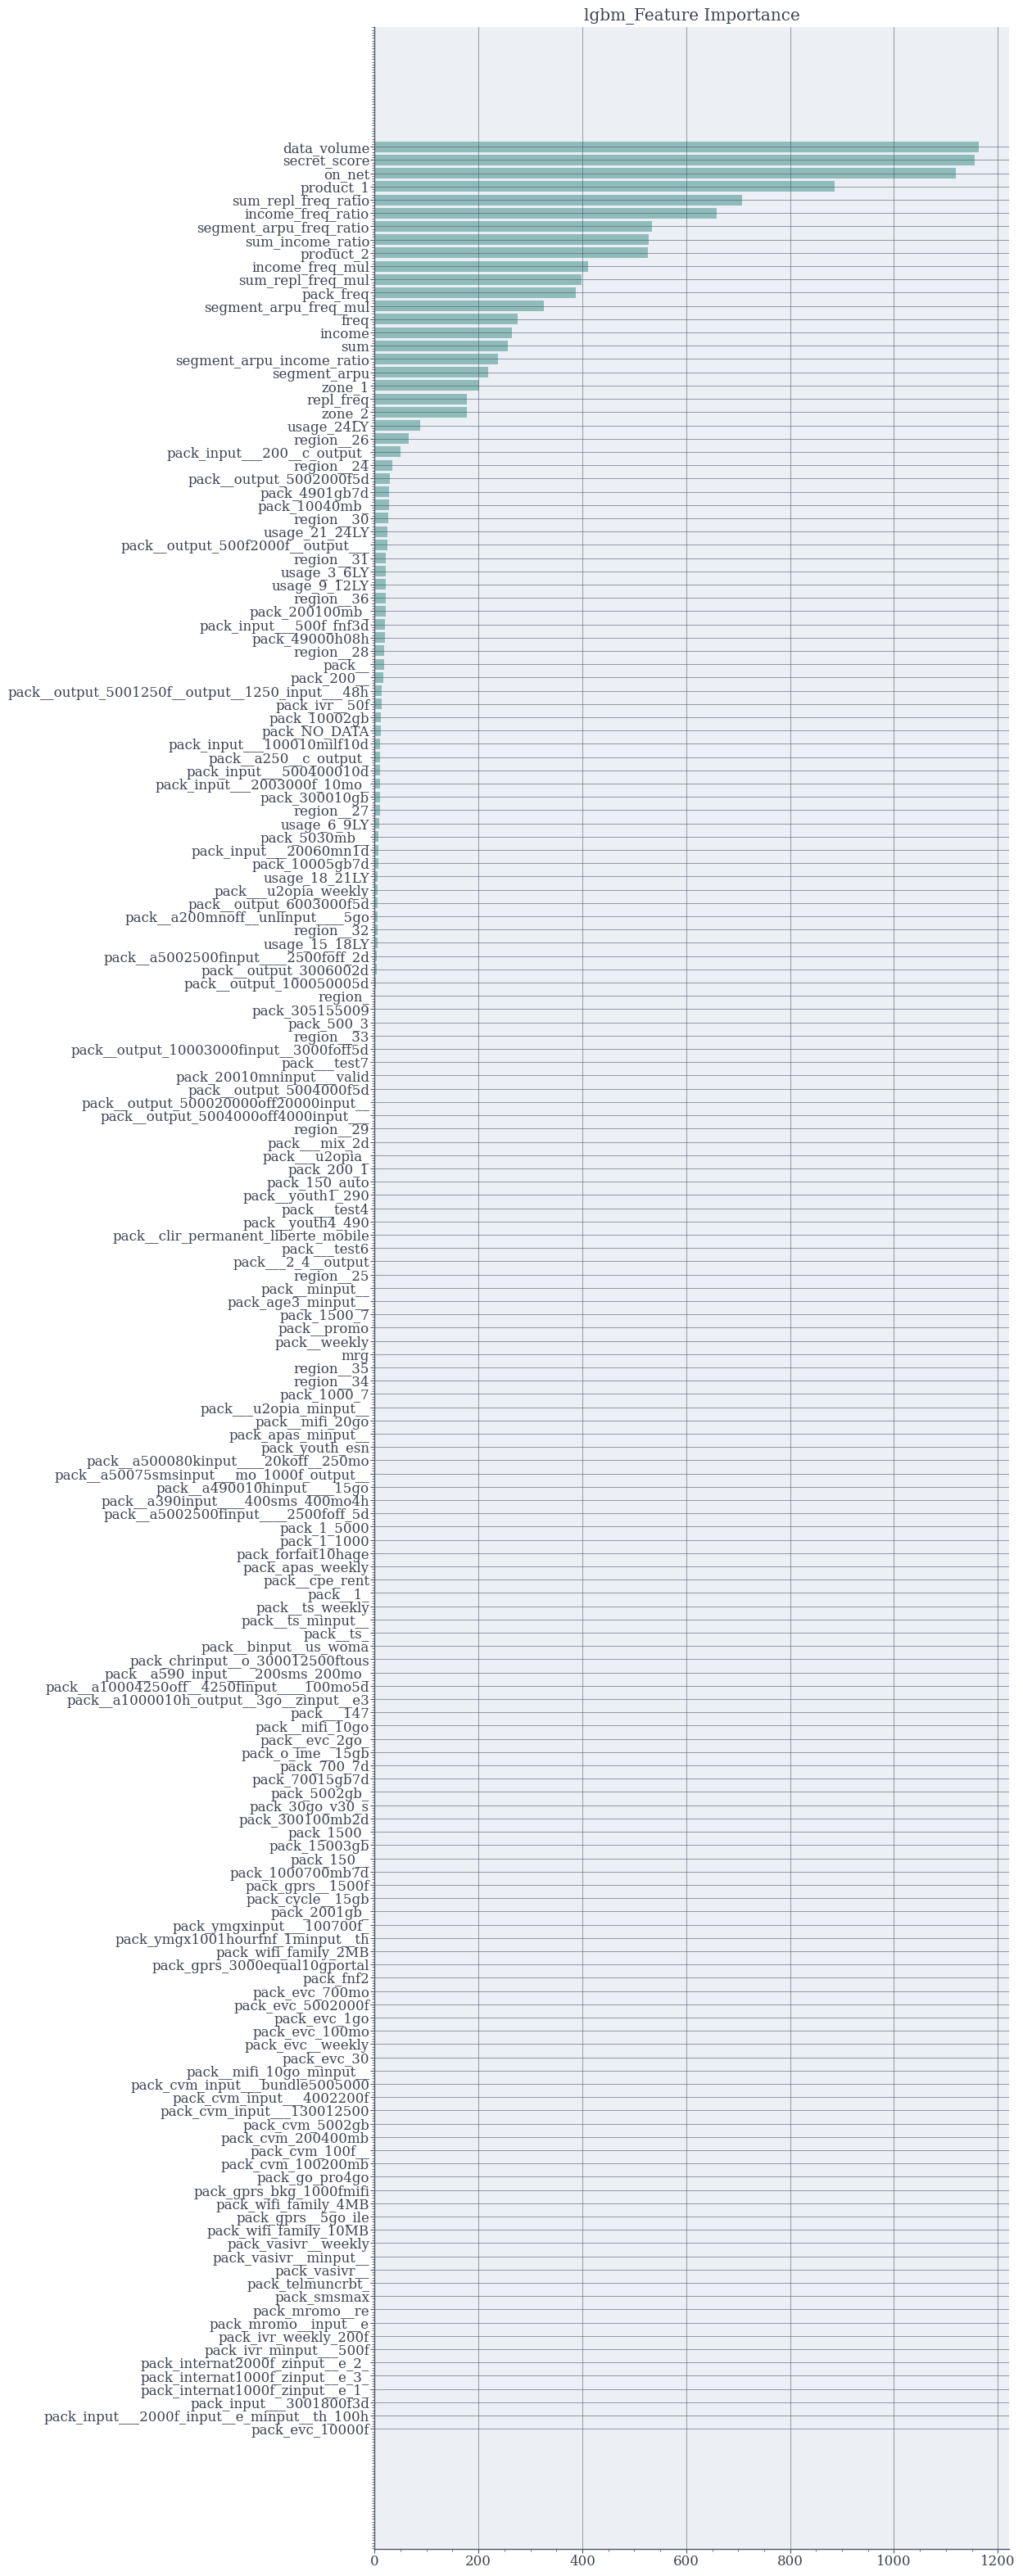

In [21]:
sorted_idx = np.argsort(clf_lgb.feature_importances_)
fig = plt.figure(figsize=(10, 40))
plt.barh(range(len(sorted_idx)), clf_lgb.feature_importances_[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.title('lgbm_Feature Importance')
plt.show()

### Tuning Hyperparametrs CatBoost

In [38]:
# def objective(trial):
#     params = {
#         "random_state": 42,
#         "random_strength": 5,
#         "loss_function": "Logloss",
#         "scale_pos_weight": 1.9,
#         "grow_policy": "Lossguide",
#         "verbose": 0,

#         "iterations": trial.suggest_float("iterations", 500, 1000),
#         "depth": trial.suggest_categorical("depth", [5, 8, 10, 12]),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 10),
#         "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
#     }

#     model = CatBoostClassifier(
#         **params,
#         task_type="GPU",
#     )

#     scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring=make_scorer(f1_score))

#     return np.mean(scores)

In [22]:
# # Create an Optuna study with pruning
# study = optuna.create_study(direction="maximize")
# # Perform the optimization with more trials
# study.optimize(objective, n_trials=30)

# # Get the best hyperparameters
# best_params_cb = study.best_params
# print("Best Hyperparameters for CatBoost:", best_params_cb)

# # Best Hyperparameters for CatBoost:
# # {
# #     "random_state": 42,
# #     "random_strength": 5,
# #     "loss_function": "Logloss",
# #     "scale_pos_weight": 1.9,
# #     "iterations": 713,
# #     "grow_policy": "Lossguide",
# #     "verbose": 0,
# #     "depth": 8,
# #     "min_data_in_leaf": 6,
# #     "learning_rate": 0.02539233321866018,
# # }

#### Tuned CatBoost

In [23]:
# Set parameters
params_cat = {
    "random_state": 42,
    "random_strength": 5,
    "loss_function": "Logloss",
    "scale_pos_weight": 1.9,
    "iterations": 713,
    "grow_policy": "Lossguide",
    "verbose": 0,
    "depth": 8,
    "min_data_in_leaf": 6,
    "learning_rate": 0.02539233321866018,
}

clf_cat = CatBoostClassifier(
    **params_cat,
    task_type="GPU",
)

clf_cat.fit(
    X_train,
    y_train,
)

f1_score(y_test, clf_cat.predict(X_test))

0.651674100131918

Feature importance for CatBoost

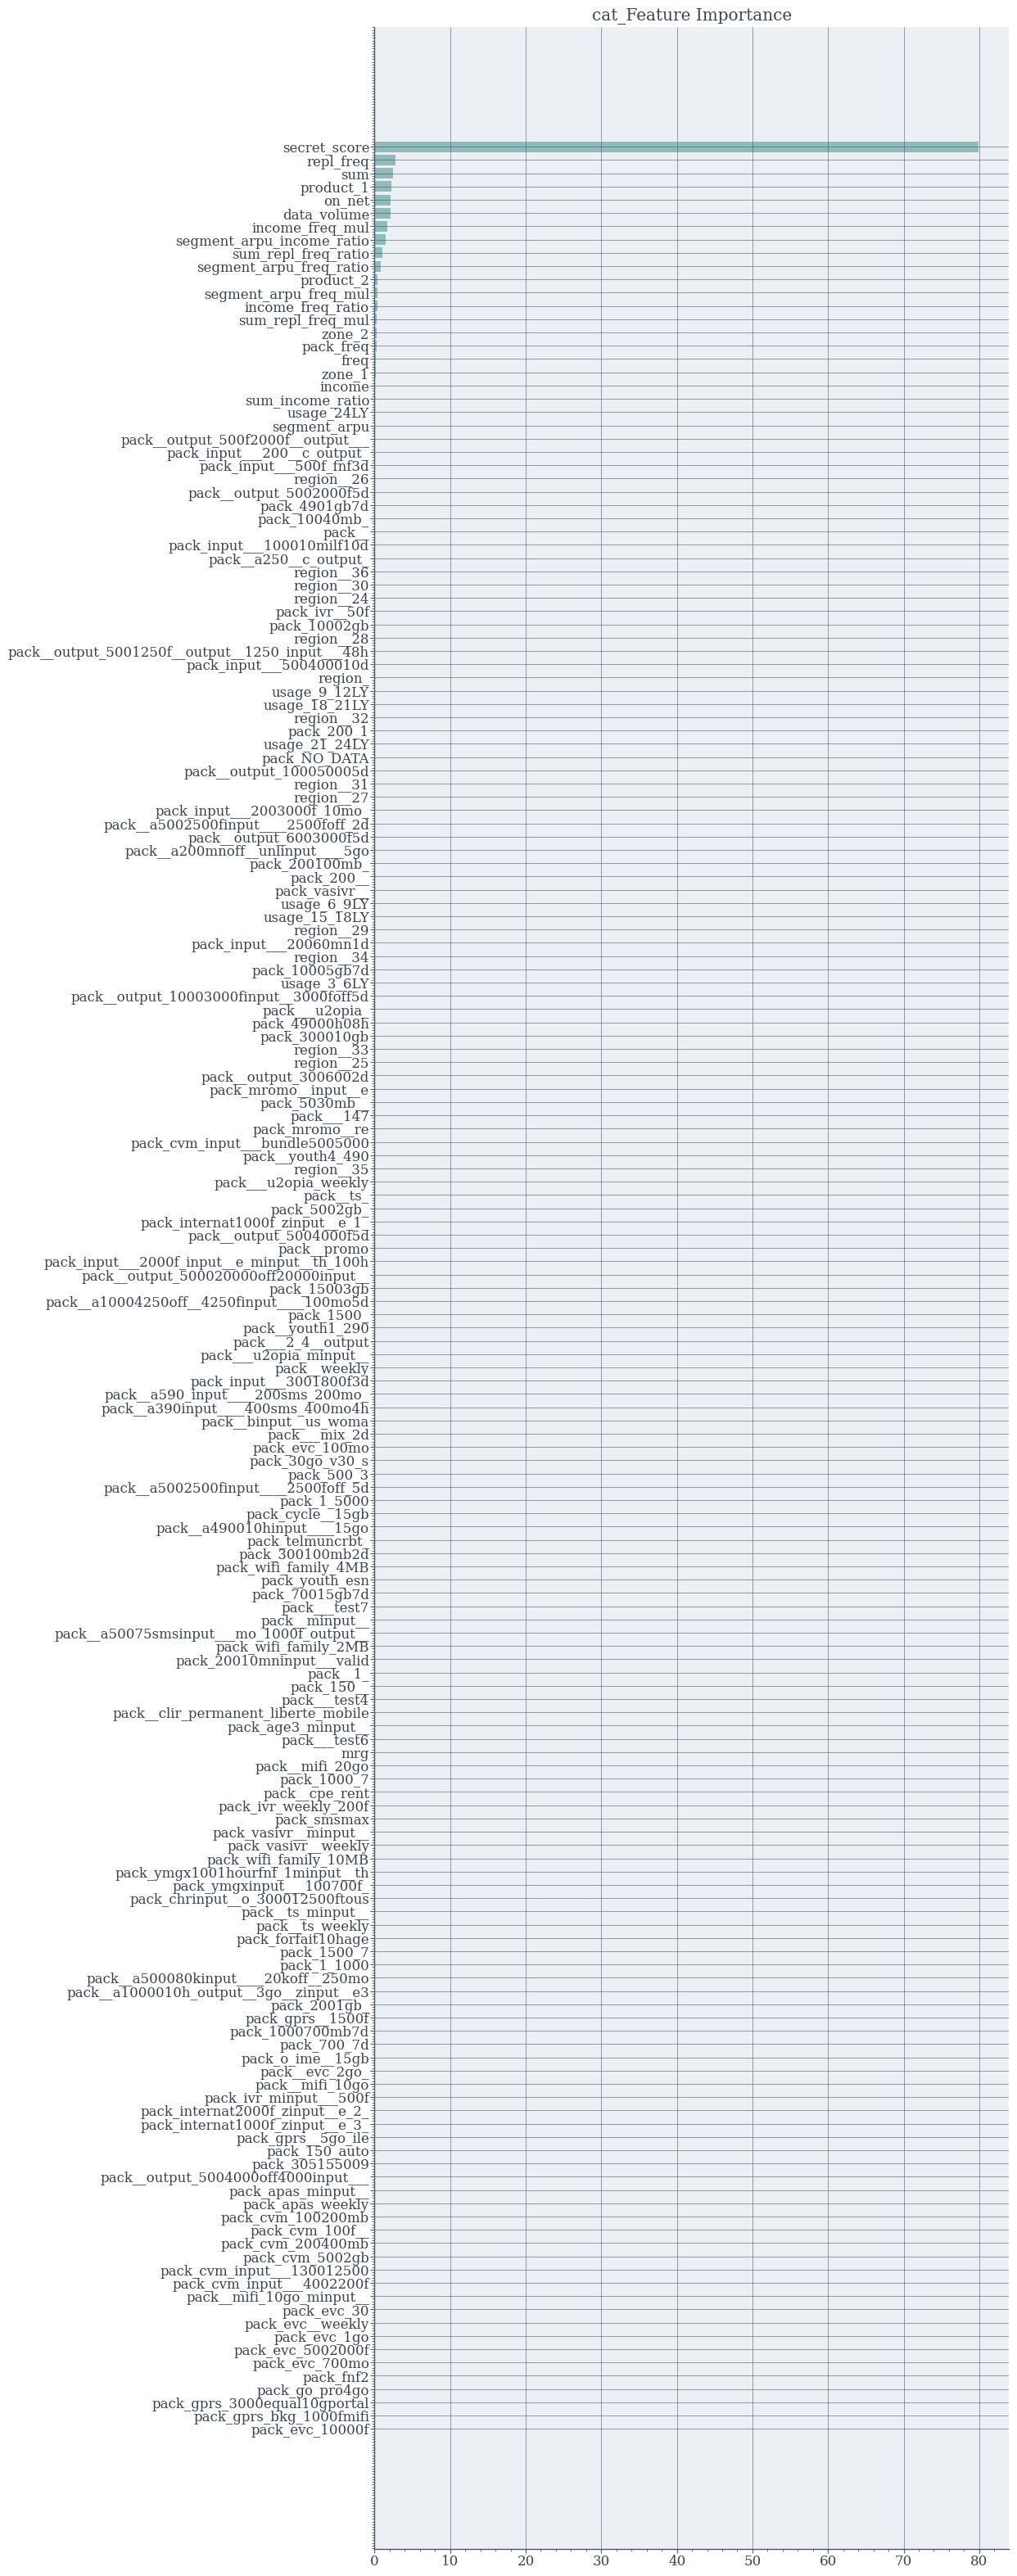

In [24]:
sorted_idx = np.argsort(clf_cat.feature_importances_)
fig = plt.figure(figsize=(10, 40))
plt.barh(range(len(sorted_idx)), clf_cat.feature_importances_[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.title('cat_Feature Importance')
plt.show()

### Tuning Hyperparametrs XGBoost

In [25]:
# def objective(trial, data=X_train, target=y_train):

#     param = {
#         "subsample": 0.9,
#         "colsample_bytree": 0.7,
#         "objective": "binary:logistic",
#         "scale_pos_weight": 1.9,
#         "learning_rate": trial.suggest_float("learning_rate", 0.1, 0.15),
#         "reg_alpha": trial.suggest_float("reg_alpha", 7.5, 8.0),
#         "reg_lambda": trial.suggest_float("reg_lambda", 8.2, 8.7),
#         "max_depth": trial.suggest_categorical(
#             "max_depth",
#             [
#                 8,
#                 12,
#             ],
#         ),
#         "max_leaves": trial.suggest_categorical(
#             "max_leaves",
#             [
#                 21,
#                 35,
#                 37,
#                 39,
#             ],
#         ),
#     }
#     model = XGBClassifier(**param)

#     scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring=make_scorer(f1_score))

#     return np.mean(scores)

In [76]:
# # Create an Optuna study with pruning
# study = optuna.create_study(direction="maximize")

# # Perform the optimization with more trials
# study.optimize(objective, n_trials=50)

# # Get the best hyperparameters
# best_params_cb = study.best_params
# print("Best Hyperparameters for XGBoost:", best_params_cb)

# Best Hyperparameters for XGBoost:
# {
#     "learning_rate": 0.10356386736632238,
#     "reg_alpha": 7.62203036251163,
#     "reg_lambda": 8.498427926200035,
#     "max_depth": 12,
#     "max_leaves": 39,
# }

#### Tuned XGBoost

In [26]:
from xgboost import XGBClassifier

params_xgb = {
    "learning_rate": 0.10356386736632238,
    "reg_alpha": 7.62203036251163,
    "reg_lambda": 8.498427926200035,
    "max_depth": 12,
    "max_leaves": 39,
    "subsample": 0.9,
    "colsample_bytree": 0.7,
    "objective": "binary:logistic",
    "scale_pos_weight": 1.9,
}

clf_xgb = XGBClassifier(**params_xgb)

clf_xgb.fit(
    X_train,
    y_train,
    verbose=0,
)


f1_score(y_test, clf_xgb.predict(X_test))

0.6519416979336276

Feature importance xgb

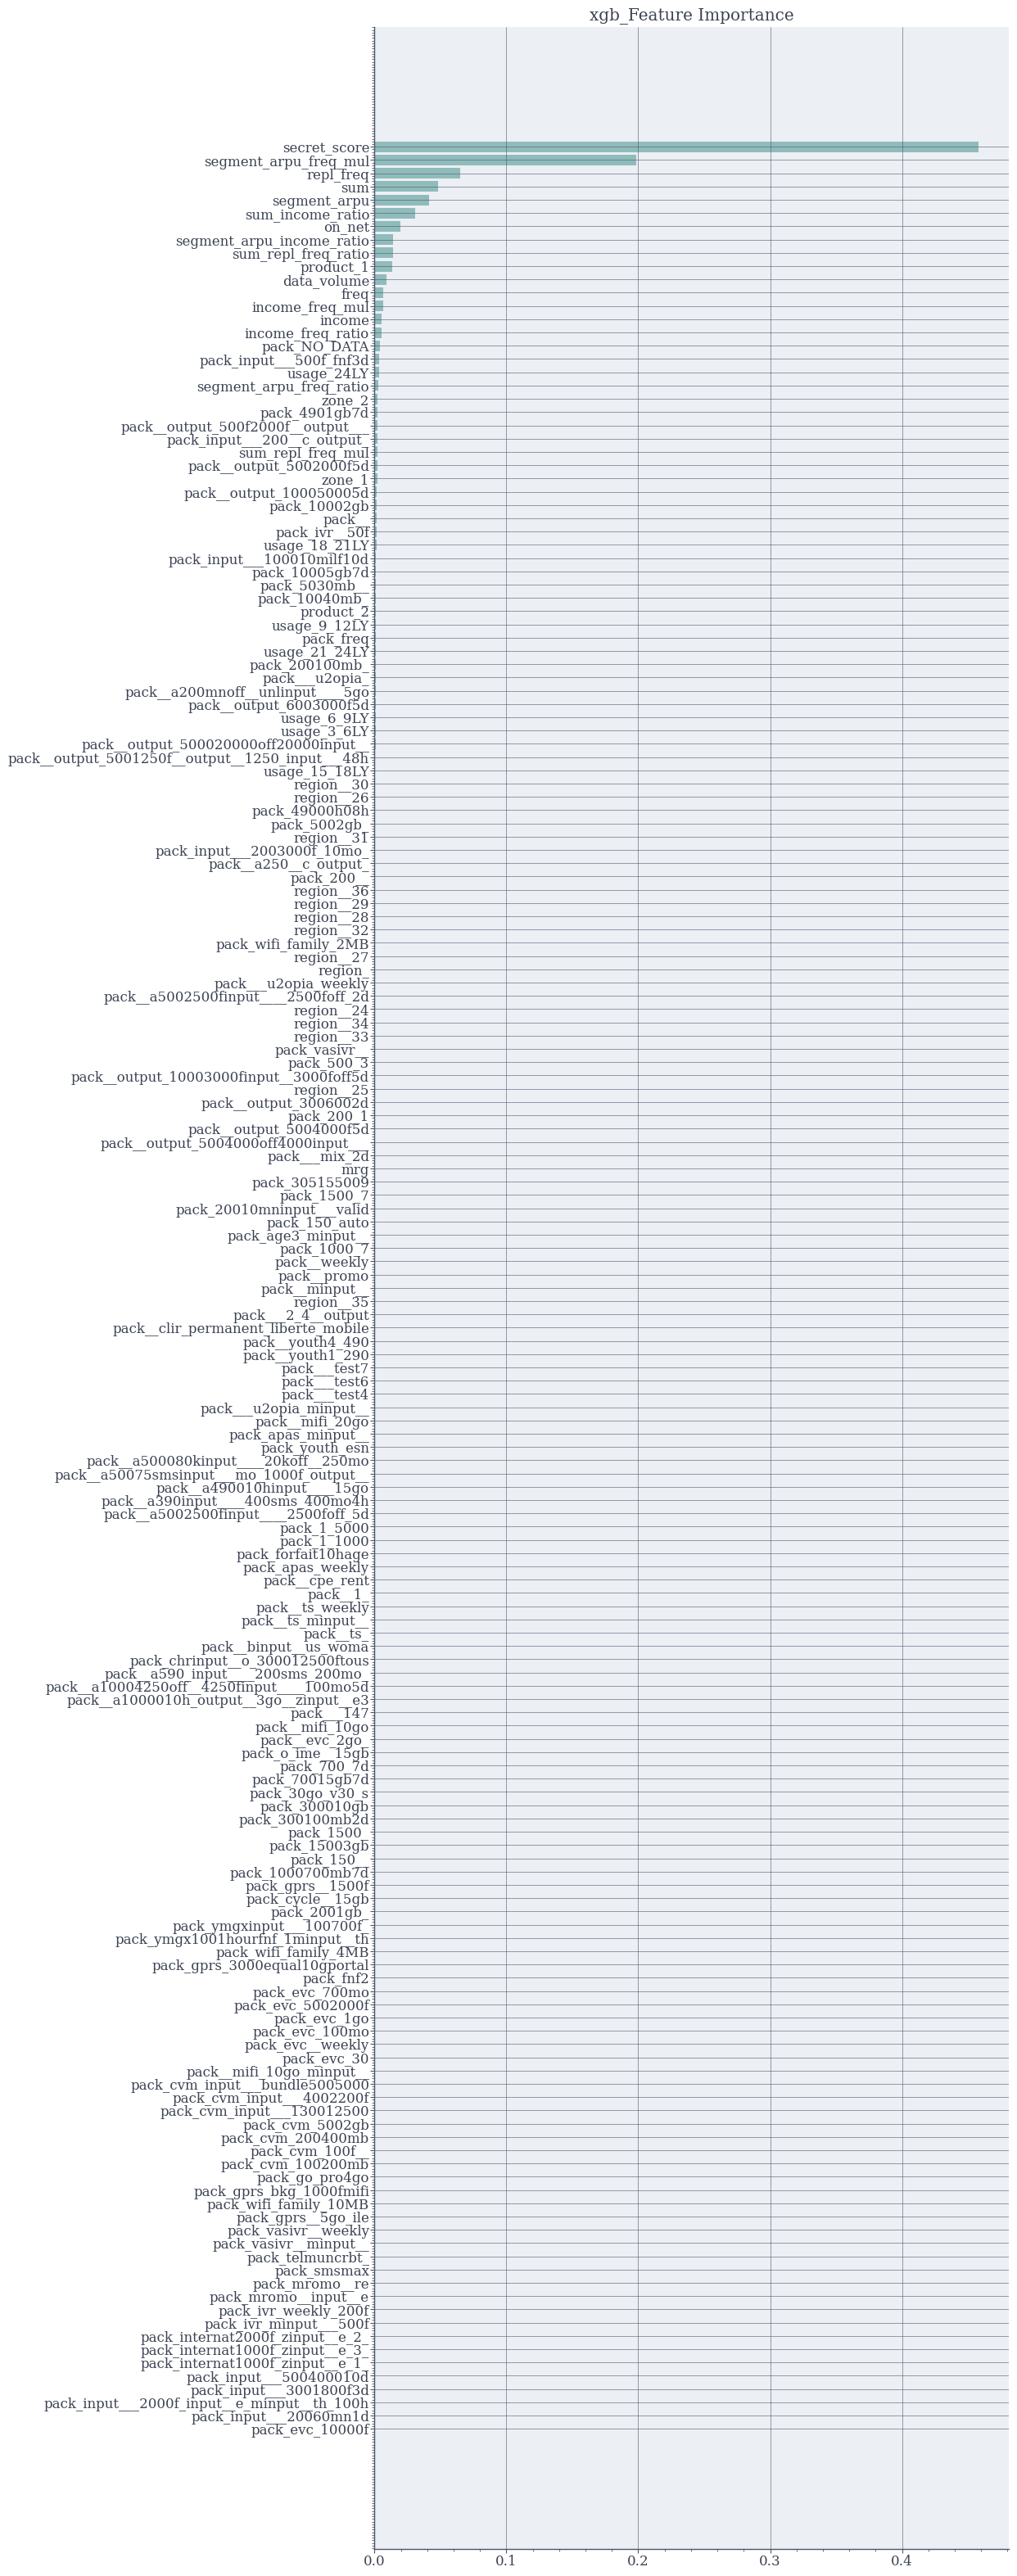

In [27]:
sorted_idx = np.argsort(clf_xgb.feature_importances_)
fig = plt.figure(figsize=(10, 40))
plt.barh(range(len(sorted_idx)), clf_xgb.feature_importances_[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.title('xgb_Feature Importance')
plt.show()

## Ансамблирование моделей

In [28]:
from sklearn.ensemble import VotingClassifier

In [29]:
ensemble_model = VotingClassifier(
    estimators=[
        ("xgb", clf_xgb),
        ("lgb", clf_lgb),
        ("cb", clf_cat),
    ],
    voting="soft",
)

ensemble_model

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.7, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                              LGBMClassifier(colsample_bytree=0.7011475694498086,
                                             learning_rate=0.0842898942177481,
                                             max_depth=10, metric='f1',
                                             min_child_samples=62,
                                             n_estimators=600, num_leaves=20,
                                             objective='binary',
                                             reg_alpha=8.051299025874005,
                                             reg_lambda=6.048611640153659,
                                             scale_pos_weight=1.9,
                                             subsample=0.9, verbosity=-1)),
                             ('cb',
                              <catboost.core.CatBoostClassifier object at 0x7f58ec7af7d0>)],
                 voting='soft')

In [30]:
ensemble_model.fit(X_train, y_train)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.7, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                              LGBMClassifier(colsample_bytree=0.7011475694498086,
                                             learning_rate=0.0842898942177481,
                                             max_depth=10, metric='f1',
                                             min_child_samples=62,
                                             n_estimators=600, num_leaves=20,
                                             objective='binary',
                                             reg_alpha=8.051299025874005,
                                             reg_lambda=6.048611640153659,
                                             scale_pos_weight=1.9,
                                             subsample=0.9, verbosity=-1)),
                             ('cb',
                              <catboost.core.CatBoostClassifier object at 0x7f58ec7af7d0>)],
                 voting='soft')

In [32]:
from sklearn.metrics import classification_report

print(f1_score(y_test, ensemble_model.predict(X_test)))
print(classification_report(y_test, ensemble_model.predict(X_test)))

0.6518754962930351
              precision    recall  f1-score   support

           0       0.93      0.88      0.91    246289
           1       0.59      0.73      0.65     56786

    accuracy                           0.85    303075
   macro avg       0.76      0.81      0.78    303075
weighted avg       0.87      0.85      0.86    303075



## Подготовка сабмита

In [34]:
df_submit_all

,sum,repl_freq,income,segment_arpu,freq,data_volume,on_net,product_1,product_2,zone_1,...,pack_4901gb7d,pack_5030mb__,pack_5002gb_,pack_70015gb7d,pack_700_7d,pack_o_ime__15gb,pack__evc_2go_,pack__mifi_10go,pack__mifi_10go_minput__,pack__mifi_20go
1010248,0.670333,0.713730,-1.220174,-1.000450,-1.402659,-1.014099,-0.872804,-1.139653,-0.815740,-0.292699,...,0,0,0,0,0,0,0,0,0,0
1010249,-1.358113,-1.358925,-1.220174,-1.000450,-1.402659,-1.014099,-0.872804,-1.139653,-0.815740,-0.292699,...,0,0,0,0,0,0,0,0,0,0
1010250,0.688914,0.717871,0.098329,-0.058135,0.709661,0.917751,0.226685,0.663710,-0.815740,3.416481,...,0,0,0,0,0,0,0,0,0,0
1010251,0.730585,0.726154,0.679872,0.279106,0.711588,0.930519,0.342874,0.859534,1.181975,-0.292699,...,0,0,0,0,0,0,0,0,0,0
1010252,-1.358113,-1.358925,-1.220174,-1.000450,-1.402659,-1.014099,-0.872804,-1.139653,-0.815740,-0.292699,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1507829,0.761679,0.740648,1.015929,0.688638,0.713898,-1.014099,0.361163,1.009073,1.243596,-0.292699,...,0,0,0,0,0,0,0,0,0,0
1507830,0.670333,0.713730,-0.560436,-0.149220,0.708991,-1.014099,0.489185,0.683292,-0.815740,-0.292699,...,0,0,0,0,0,0,0,0,0,0
1507831,-1.358113,-1.358925,-1.220174,-1.000450,-1.402659,-1.014099,-0.872804,-1.139653,-0.815740,-0.292699,...,0,0,0,0,0,0,0,0,0,0
1507832,0.709771,0.722012,0.415823,0.080307,0.710724,0.915821,0.227761,0.693974,-0.815740,-0.292699,...,0,0,0,0,0,0,0,0,0,0


In [35]:
sub_pred = ensemble_model.predict(df_submit_all)

In [36]:
sub_pred.shape

(497586,)

In [37]:
submission["preds"] = sub_pred
submission

,client_id,preds
0,1010248,0
1,1010249,0
2,1010250,0
3,1010251,0
4,1010252,0
...,...,...
497581,1507829,0
497582,1507830,0
497583,1507831,1
497584,1507832,0


### Экспорт csv

In [38]:
submission.to_csv("./sub_10.csv", index=False)